In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import hdbscan
import geopandas as gpd
import contextily as ctx

In [2]:
import requests
import zipfile
import io
import os

zip_file_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip"

output_dir = './'
os.makedirs(output_dir , exist_ok=True)

response = requests.get(zip_file_url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    for file_name in zip_ref.namelist():
        if file_name.endswith('.tif'):
            zip_ref.extract(file_name , output_dir)
            print(f"Downloaded and Extracted {file_name}")

Downloaded and Extracted Canada.tif


In [3]:
# Write a function that plots clustered locations and overlays them on a basemap.

def plot_clustered_locations(df,  title='Museums Clustered by Proximity'):
    """
    Plots clustered locations and overlays on a basemap.
    
    Parameters:
    - df: DataFrame containing 'Latitude', 'Longitude', and 'Cluster' columns
    - title: str, title of the plot
    """
    
    # Load the coordinates intto a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326")
    
    # Reproject to Web Mercator to align with basemap 
    gdf = gdf.to_crs(epsg=3857)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Separate non-noise, or clustered points from noise, or unclustered points
    non_noise = gdf[gdf['Cluster'] != -1]
    noise = gdf[gdf['Cluster'] == -1]
    
    # Plot noise points 
    noise.plot(ax=ax, color='k', markersize=30, ec='r', alpha=1, label='Noise')
    
    # Plot clustered points, colured by 'Cluster' number
    non_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, ec='k', legend=False, alpha=0.6)
    
    # Add basemap of  Canada
    ctx.add_basemap(ax, source='./Canada.tif', zoom=4)
    
    # Format plot
    plt.title(title, )
    plt.xlabel('Longitude', )
    plt.ylabel('Latitude', )
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [4]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(url, encoding = "ISO-8859-1")

In [5]:
df.head()

Index                      Facility_Name  ...     Latitude     Longitude
0      1                   #Hashtag Gallery  ...  43.65169472  -79.40803272
1      2  'Ksan Historical Village & Museum  ...   55.2645508  -127.6428124
2      3               'School Days' Museum  ...    45.963283   -66.6419017
3      4                   10 Austin Street  ...  46.09247776  -64.78022946
4      5              10 Gates Dancing Inc.  ...  45.40856224  -75.71536766

[5 rows x 17 columns]

In [6]:
# your code here
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
library or archives                     3013
museum                                  1938
gallery                                  810
heritage or historic site                620
theatre/performance and concert hall     583
festival site                            346
miscellaneous                            343
art or cultural centre                   225
artist                                    94
Name: count, dtype: int64

In [7]:
df = df[df.ODCAF_Facility_Type == 'museum']
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
museum    1938
Name: count, dtype: int64

In [8]:
df = df[['Latitude', 'Longitude']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   1938 non-null   object
 1   Longitude  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


In [9]:
df = df[df.Latitude!='..']

# Convert to float
df[['Latitude','Longitude']] = df[['Latitude','Longitude']].astype('float')

In [10]:
coords_scaled = df.copy()
coords_scaled["Latitude"] = 2*coords_scaled["Latitude"]

In [11]:
dbscan  = DBSCAN(eps = 1.0 , min_samples=3 , metric='euclidean').fit(coords_scaled)

In [12]:
df['Cluster'] = dbscan.fit_predict(coords_scaled)  # Assign the cluster labels

# Display the size of each cluster
df['Cluster'].value_counts()

Cluster
 4     701
 2     192
 1     181
 7     134
 3      94
-1      79
 6      30
 10     27
 8      21
 11     15
 15     13
 20     11
 16     10
 19      9
 27      8
 12      7
 24      6
 18      6
 28      6
 26      6
 14      6
 5       6
 22      4
 9       4
 13      4
 30      3
 31      3
 29      3
 0       3
 25      3
 23      3
 21      3
 17      3
 32      3
Name: count, dtype: int64

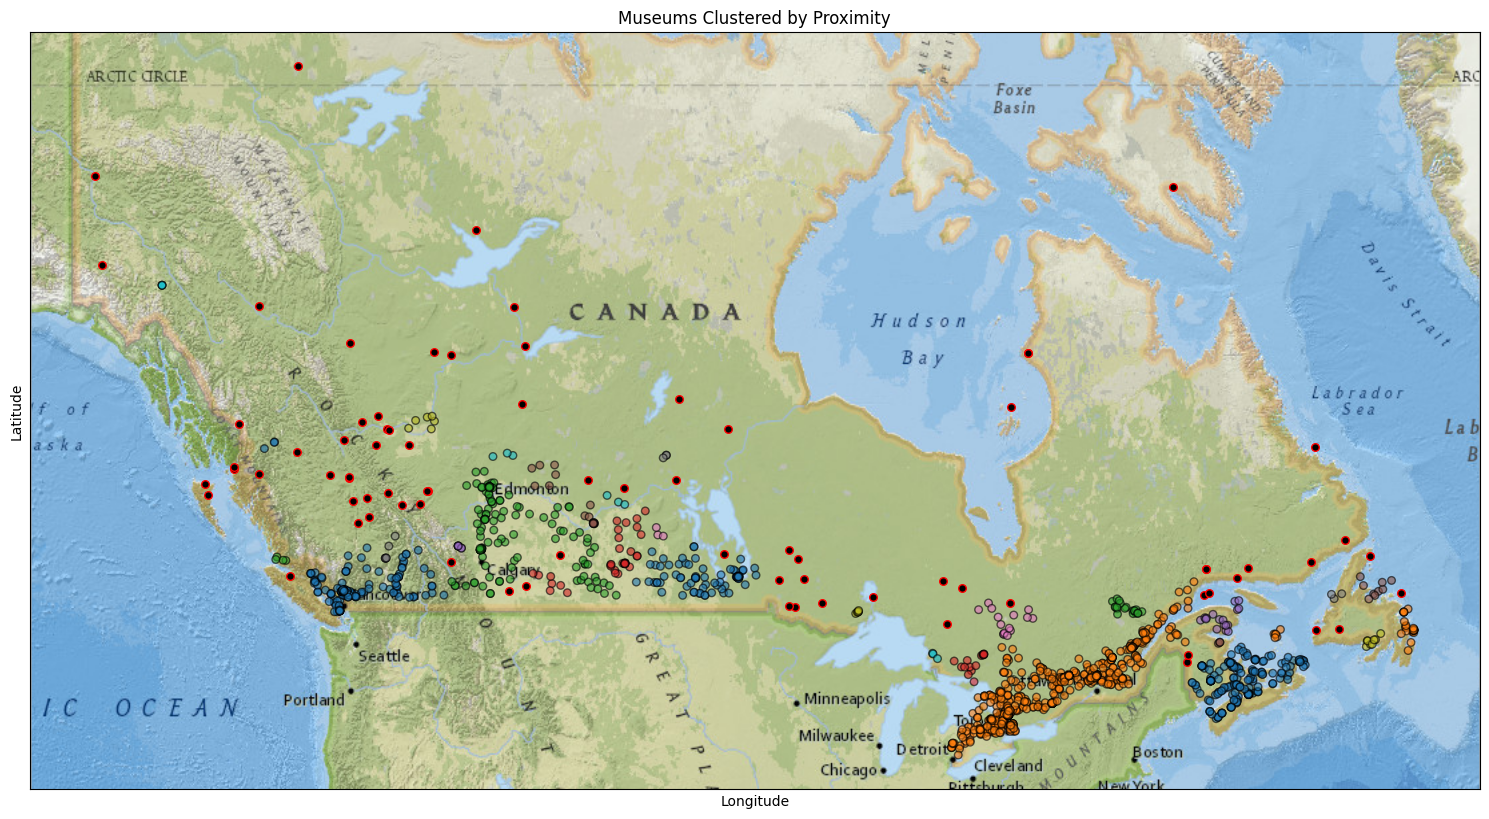

In [13]:
plot_clustered_locations(df, title='Museums Clustered by Proximity')

In [14]:
hdb = hdbscan.HDBSCAN(min_samples=None, min_cluster_size = 3, metric='euclidean')

In [15]:
df['Cluster'] = hdb.fit_predict(coords_scaled)  # Another way to assign the labels

# Display the size of each cluster
df['Cluster'].value_counts()

Cluster
-1      462
 139     45
 94      39
 59      34
 84      28
       ... 
 0        3
 135      3
 103      3
 111      3
 44       3
Name: count, Length: 143, dtype: int64

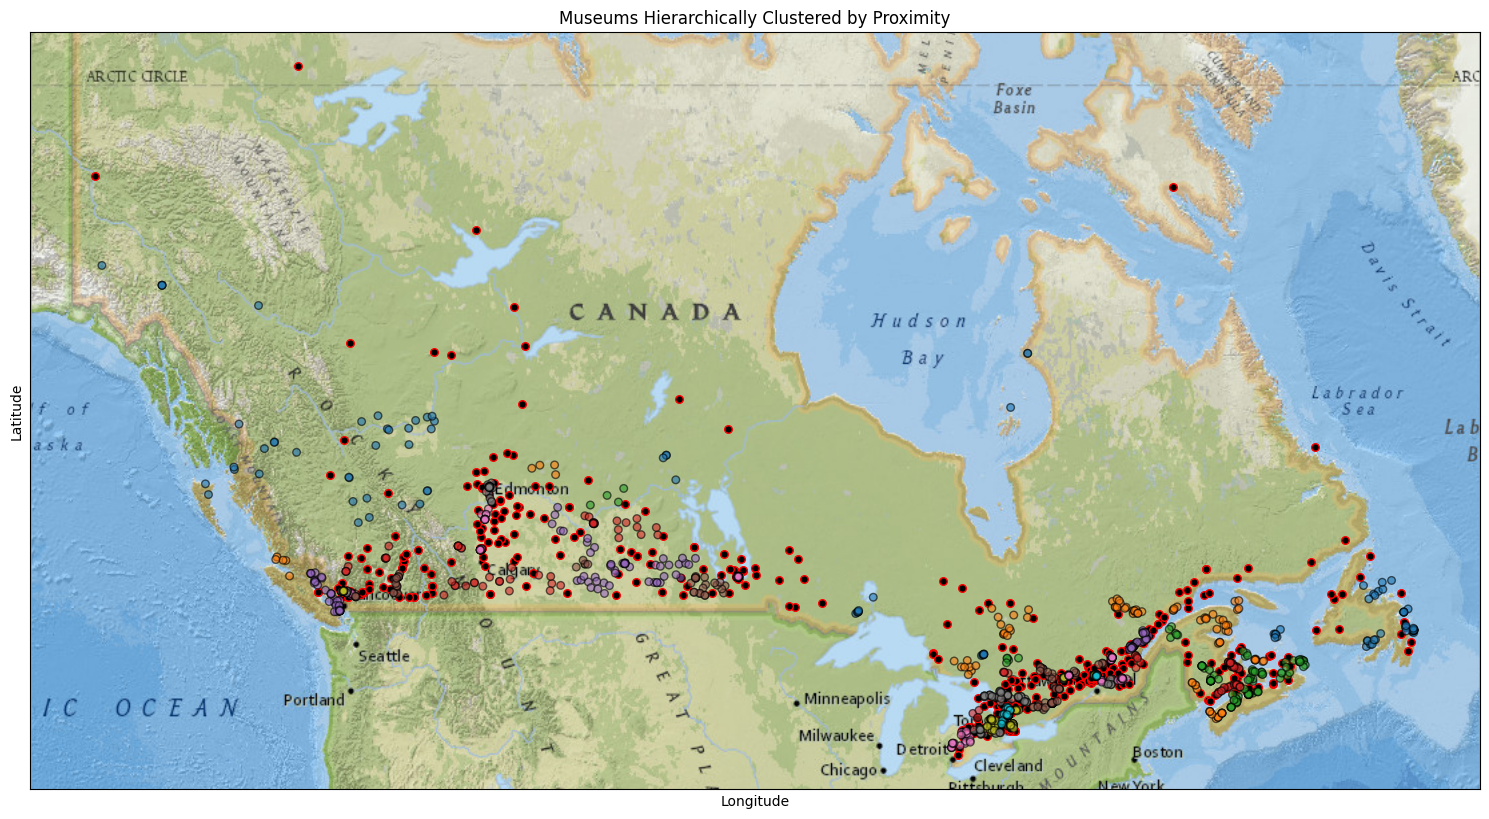

In [16]:
plot_clustered_locations(df, title='Museums Hierarchically Clustered by Proximity')